In [6]:
import numpy as np
from scipy.sparse import coo_matrix
import gurobipy as gp
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Function to load the intensity matrix from CSV or Image
def load_data(file_path):
    if file_path.endswith('.csv'):
        # Load CSV file as intensity matrix
        intensity_matrix = pd.read_csv(file_path, header=None)
    else:
        # Load image file and convert it to grayscale intensity matrix
        image = Image.open(file_path)
        grayscale_img = image.convert("L").convert('L')
        pixel_table = list(grayscale_img.getdata())
        width, height = grayscale_img.size
        pixel_table = [pixel_table[i * width:(i + 1) * width] for i in range(height)]

        #the image is a 128*128 matrix
        # Display the pixel table
        # for row in pixel_table:
        #     print(row)

        intensity_matrix = pd.DataFrame(pixel_table)
    return intensity_matrix

# Function to calculate source and sink indices based on user coordinates
def connect_source_sink(image_size, background_x, background_y, foreground_x, foreground_y):
    """
    Converts user-provided coordinates to indices for source (background pixel)
    and sink (foreground pixel).
    """
    if ((background_x >image_size-1) or (background_y>image_size-1) or (foreground_x>image_size-1) or (foreground_x>image_size-1)):
      print("Coordinates out of bounds")
      return (image_size-1),(image_size-1)
    # Calculate pixel indices for source and sink
    else:
      print(f"Background coordinates: ({background_x}, {background_y})")
      print(f"Foreground coordinates: ({foreground_x}, {foreground_y})")
      background_pixel = background_x * image_size + background_y
      foreground_pixel = foreground_x * image_size + foreground_y
      print(f"Background pixel index: {background_pixel}")
      print(f"Foreground pixel index: {foreground_pixel}")

    # error part do later

    return background_pixel, foreground_pixel

# Step 1: Calculate similarity based on pixel intensity differences
def calculate_similarity(Ii, Ij, sigma):
    # Gaussian similarity based on pixel intensity difference
    return np.exp(-(Ii - Ij) ** 2 / (2 * sigma ** 2))

# Step 2: Construct sparse network matrix based on pixel similarities
def construct_network_sparse(pixel_data, background_pixel, foreground_pixel, sigma, threshold=0.3):
    intensity_matrix = pixel_data
    image_size = intensity_matrix.shape[0]
    num_nodes = image_size * image_size + 2  # Including source and sink

    # Lists to store row indices, column indices, and the values of the non-zero entries
    row_indices = []
    col_indices = []
    data = []

    source_node = num_nodes - 2
    sink_node = num_nodes - 1

    print(f"Image size: {image_size}x{image_size}")
    print(f"Number of nodes (including source and sink): {num_nodes}")
    print(f"Background pixel index: {background_pixel}, Foreground pixel index: {foreground_pixel}")

    # Single loop to process each pixel and its neighbors
    for pixel in range(image_size * image_size):
        # Get the row and column of the current pixel
        row, col = divmod(pixel, image_size)
        Ii = intensity_matrix.iloc[row, col]

        # Horizontal neighbors
        if col < image_size - 1:
            neighbor = pixel + 1
            Ij = intensity_matrix.iloc[row, col + 1]
            similarity = calculate_similarity(Ii, Ij, sigma)
            # Add non-zero entries
            row_indices.append(pixel)
            col_indices.append(neighbor)
            data.append(similarity)
            row_indices.append(neighbor)
            col_indices.append(pixel)
            data.append(similarity)
            # print(f"Horizontal neighbors ({row}, {col}) <-> ({row}, {col+1}): Similarity = {similarity}")

        # Vertical neighbors
        if row < image_size - 1:
            neighbor = pixel + image_size
            Ij = intensity_matrix.iloc[row + 1, col]
            similarity = calculate_similarity(Ii, Ij, sigma)
            # Add non-zero entries
            row_indices.append(pixel)
            col_indices.append(neighbor)
            data.append(similarity)
            row_indices.append(neighbor)
            col_indices.append(pixel)
            data.append(similarity)
            # print(f"Vertical neighbors ({row}, {col}) <-> ({row+1}, {col}): Similarity = {similarity}")

        # Add source/sink connections based on threshold
        if intensity_matrix.iloc[row, col] < threshold:
            row_indices.append(source_node)
            col_indices.append(pixel)
            data.append(100)  # Strong connection to source
            # print(f"Source to pixel ({row}, {col}) connection with weight = 100")
        else:
            row_indices.append(pixel)
            col_indices.append(sink_node)
            data.append(100)  # Strong connection to sink
            # print(f"Pixel ({row}, {col}) to sink connection with weight = 100")

    # Add strong connections for specific background and foreground pixels
    row_indices.append(source_node)
    col_indices.append(background_pixel)
    data.append(100)
    # print(f"Source to background pixel connection (pixel {background_pixel}) with weight = 100")

    row_indices.append(foreground_pixel)
    col_indices.append(sink_node)
    data.append(100)
    # print(f"Foreground pixel to sink connection (pixel {foreground_pixel}) with weight = 100")

    # Convert the lists of rows, cols, and data into a sparse COO matrix
    network_sparse = coo_matrix((data, (row_indices, col_indices)), shape=(num_nodes, num_nodes))

    print("Sparse network matrix constructed.")
    print(f"Non-zero elements in the sparse matrix: {network_sparse.nnz}")

    return network_sparse, intensity_matrix, source_node, sink_node

# Step 3: Segment the image using max-flow/min-cut and visualize
def segment_image(network_sparse, intensity_matrix, source_node, sink_node):
    # Create the Gurobi model
    mod = gp.Model("max_flow_image_segmentation")
    num_nodes = network_sparse.shape[0]
    image_size = intensity_matrix.shape[0]

    print(f"Starting segmentation with {num_nodes} nodes and image size {image_size}x{image_size}")

    # Extract the non-zero indices and values from the sparse matrix (in COO format)
    row_indices = network_sparse.row
    col_indices = network_sparse.col
    ub_values = network_sparse.data

    # Add a matrix of decision variables with upper bounds for non-zero entries only
    flow = {}
    for i, j, ub in zip(row_indices, col_indices, ub_values):
        flow[(i, j)] = mod.addVar(ub=ub, vtype=gp.GRB.CONTINUOUS, name=f"flow_{i}_{j}")

    # Set the objective to maximize the flow from the source node
    mod.setObjective(gp.quicksum(flow[(source_node, j)] for j in range(num_nodes) if (source_node, j) in flow), gp.GRB.MAXIMIZE)

    # Adding flow conservation constraints for every pixel node (excluding source and sink)
    print("Adding flow conservation constraints...")
    for node in range(num_nodes):
        if node not in [source_node, sink_node]:
            inflow = gp.quicksum(flow[(i, node)] for i in range(num_nodes) if (i, node) in flow)
            outflow = gp.quicksum(flow[(node, j)] for j in range(num_nodes) if (node, j) in flow)
            mod.addConstr(inflow == outflow, name=f"flow_conservation_{node}")

    # Turn off Gurobi output to minimize excessive logging
    mod.Params.OutputFlag = 0

    # Solve the model
    print("Optimizing the model...")
    mod.optimize()

    # Checking if an optimal solution was found
    if mod.status == gp.GRB.OPTIMAL:
        print("Optimal solution found!")
        
        # Create a matrix to store the flow solution
        flow_solution = np.zeros((num_nodes, num_nodes))

        # Fill the flow solution matrix for non-zero entries
        for i, j in flow:
            flow_solution[i, j] = flow[(i, j)].X

        # Calculate the residual network
        residual_network = network_sparse - flow_solution
        print("Residual network calculated.")

        # Perform depth-first search (DFS) from the source node
        visited = np.zeros(num_nodes, dtype=bool)

        def dfs(node):
            visited[node] = True
            for neighbor in range(num_nodes):
                if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                    dfs(neighbor)

        dfs(source_node)
        print("DFS traversal completed.")

        # Optimized Cut Edges Identification using non-zero elements
        cut_edges = []

        # Iterate only over non-zero elements
        for i, j in zip(row_indices, col_indices):
            if visited[i] and not visited[j]:
                cut_edges.append((i, j))

        print(f"Found {len(cut_edges)} cut edges.")

        # Visualize the segmentation
        plt.imshow(intensity_matrix, cmap='gray', vmin=0, vmax=1)
        print("Plotting the segmentation cuts...")

        # Overlay the cuts in red
        for i, j in cut_edges:
            if i < image_size * image_size and j < image_size * image_size:
                row_i, col_i = divmod(i, image_size)
                row_j, col_j = divmod(j, image_size)
                plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)
                # plt.plot([col_i - 0.5, col_j - 0.5], [row_i + 0.5, row_j + 0.5], color='red', linewidth=2)

                # Draw rectangles around the pixels instead of lines between pixels
                # rect = plt.Rectangle((col_i - 0.5, row_i - 0.5), 1, 1, fill=False, edgecolor='red', linewidth=1.5)
                # plt.gca().add_patch(rect)

                # # Horizontal cuts (left-right edges)
                # if row_i == row_j and abs(col_i - col_j) == 1:
                #     plt.plot([col_i, col_j], [row_i - 0.5, row_i - 0.5], color='red', linewidth=1)
                
                # # Vertical cuts (top-bottom edges)
                # if col_i == col_j and abs(row_i - row_j) == 1:
                #     plt.plot([col_i - 0.5, col_i - 0.5], [row_i, row_j], color='red', linewidth=1)

        plt.title("Segmented Image with Cuts")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print("No optimal solution found.")

In [7]:
def main(file, bx, by, fx, fy, sig):
    # # Get inputs from the user
    # file_path = input("Enter the file path (CSV or Image): ")
    # background_x = int(input("Enter x coordinate of background pixel: "))
    # background_y = int(input("Enter y coordinate of background pixel: "))
    # foreground_x = int(input("Enter x coordinate of foreground pixel: "))
    # foreground_y = int(input("Enter y coordinate of foreground pixel: "))
    # sigma = float(input("Enter sigma value (controls pixel similarity): "))
    file_path = file
    background_x = bx
    background_y = by
    foreground_x = fx
    foreground_y = fy
    sigma = sig
    # Load the data
    intensity_matrix = load_data(file_path)
    # Calculate image size
    image_size = intensity_matrix.shape[0]
    # Get the source (background) and sink (foreground) indices from the coordinates
    background_pixel, foreground_pixel = connect_source_sink(image_size, background_x, background_y, foreground_x, foreground_y)
    
    # Construct the network matrix based on pixel similarities and user-specified source/sink
    network, intensity_matrix, source_node, sink_node = construct_network_sparse(intensity_matrix, background_pixel, foreground_pixel, sigma)
    # print("network")


    # # Perform segmentation
    segment_image(network,intensity_matrix, source_node, sink_node)

In [8]:

# # Step 4: Main function with grid search
# def main(file, bx, by, fx, fy, initial_sigma):
#     intensity_matrix = load_data(file)
#     image_size = intensity_matrix.shape[0]
#     background_pixel = by * image_size + bx
#     foreground_pixel = fy * image_size + fx

#     # Define parameter ranges for grid search
#     sigma_range = np.linspace(0.05, 0.1)  # Try 5 different values of sigma
#     threshold_range = np.linspace(0.2,0.3)  # Try 4 different values of threshold

#     best_result = None
#     best_cut_count = float('inf')  # Initialize with high cut count

#     for sigma in sigma_range:
#         for threshold in threshold_range:
#             print(f"Testing with sigma={sigma} and threshold={threshold}...")
#             network_sparse, intensity_matrix, source_node, sink_node = construct_network_sparse(
#                 intensity_matrix, background_pixel, foreground_pixel, sigma, threshold
#             )

#             # Perform segmentation
#             try:
#                 segment_image(network_sparse, intensity_matrix, source_node, sink_node)
#             except Exception as e:
#                 print(f"Error with sigma={sigma} and threshold={threshold}: {e}")

Background coordinates: (0, 0)
Foreground coordinates: (19, 19)
Background pixel index: 0
Foreground pixel index: 399
Image size: 20x20
Number of nodes (including source and sink): 402
Background pixel index: 0, Foreground pixel index: 399
Sparse network matrix constructed.
Non-zero elements in the sparse matrix: 1922
Starting segmentation with 402 nodes and image size 20x20
Adding flow conservation constraints...
Optimizing the model...
Optimal solution found!
Residual network calculated.
DFS traversal completed.
Found 53 cut edges.
Plotting the segmentation cuts...


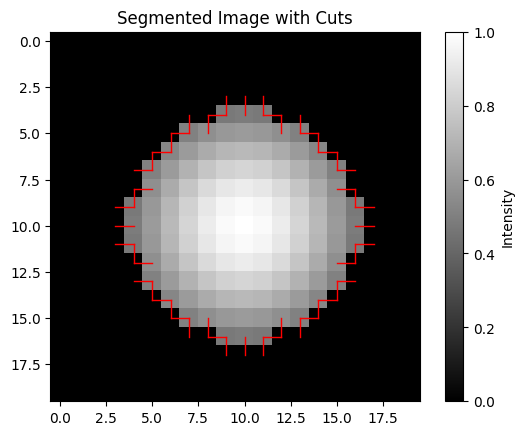

In [10]:
main('oval.csv',0,0,19,19,0.07)
